In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

**Metric:** Function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are.

### 1. Prerequisite

#### Data ingestion and preparation

In [2]:
df = pd.read_csv('data.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

#### Setting validation framework

In [3]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

#### Numerical and categorical features

In [4]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

#### Model training

In [5]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

#### Model validation

In [6]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

### 2. Accuracy and Dummy Model
- Evaluate the model on different thresholds
- Check the accuracy of dummy baseliness

In [7]:
len(y_val)

1409

In [8]:
(y_val == churn_decision).sum()

1132

In [9]:
(y_val == churn_decision).mean()

0.8034066713981547

In [10]:
1132/1409

0.8034066713981547

In [11]:
# Using sckit-learn library to calculate accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [12]:
thresholds = np.linspace(0, 1, 21)
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print("%.2f %.3f" % (t, score))
    scores.append(score)    

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


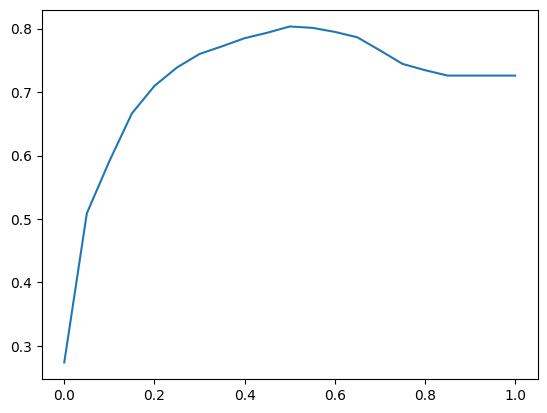

In [13]:
plt.plot(thresholds, scores)
plt.show()

In [14]:
from collections import Counter

In [15]:
Counter(y_pred > 1.0)

Counter({False: 1409})

### 3. Confusion Table
- Different types of errors and correct decisions.
- Arranging them in a table

**Postive [Churn] & Negative [Not Churn]**
- True Positive
- False Positive
- True Negative
- False Negative

In [16]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [17]:
t = 0.5

predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [18]:
# True Positive
tp = (actual_positive & predict_positive).sum()
tp

210

In [19]:
# True Negative
tn = (actual_negative & predict_negative).sum()
tn

922

In [20]:
# False Postive
fp =(actual_negative & predict_positive).sum()
fp

101

In [21]:
# False Negative
fn = (actual_positive & predict_negative).sum()
fn

176

In [22]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[922, 101],
       [176, 210]])

In [23]:
# Normalizing the values
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

In [24]:
# accuracy = tn + tp
accuracy = 0.65 + 0.15
accuracy

0.8

### 4. Precision & Recall

In [25]:
# Accuracy calculation from confusion matrix
accuracy = (tp + tn) / ( tp + fp + tn + fn)
accuracy

0.8034066713981547

**Precision:** Fraction of postive prediction that are correct.

In [26]:
p = tp / (tp + fp)
p

0.6752411575562701

**Recall:** Positive prediction which correctly identified. 

In [27]:
r = tp / (tp + fn)
r

0.5440414507772021

### 5. ROC Curves and Plotting

#### TPR & FPR
- **TPR:** True Positive Rate
- **FPR:** False Positive Rate

In [28]:
tpr = tp  / (tp + fn)
tpr

0.5440414507772021

In [29]:
fpr= fp / (fp + tn)
fpr

0.09872922776148582

In [30]:
scores = []
thresholds = np.linspace(0, 1, 101 )

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (actual_positive & predict_positive).sum()
    fp = (actual_negative & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    fn = (actual_positive & predict_negative).sum()

    tpr = tp  / (tp + fn)
    fpr= fp / (fp + tn)

    scores.append((t, tp, fp, tn, fn, tpr, fpr))    

In [31]:
columns = ['threshold', 'tp', 'fp', 'tn', 'fn', 'tpr', 'fpr']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,threshold,tp,fp,tn,fn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,913,110,1,0.997409,0.892473
2,0.02,384,830,193,2,0.994819,0.811339
3,0.03,383,766,257,3,0.992228,0.748778
4,0.04,381,715,308,5,0.987047,0.698925


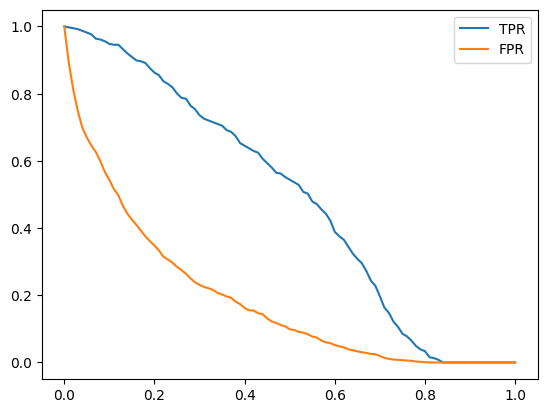

In [32]:
# Plotting the graph
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()
plt.show()

#### Random Model

In [33]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [34]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [35]:
def tpr_fpr_dataframes(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101 )
    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
    
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (actual_positive & predict_positive).sum()
        fp = (actual_negative & predict_positive).sum()
        tn = (actual_negative & predict_negative).sum()
        fn = (actual_positive & predict_negative).sum()
    
        tpr = tp  / (tp + fn)
        fpr= fp / (fp + tn)
    
        scores.append((t, tp, fp, tn, fn, tpr, fpr))
        
    columns = ['threshold', 'tp', 'fp', 'tn', 'fn', 'tpr', 'fpr']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

In [36]:
df_rand = tpr_fpr_dataframes(y_val, y_rand)

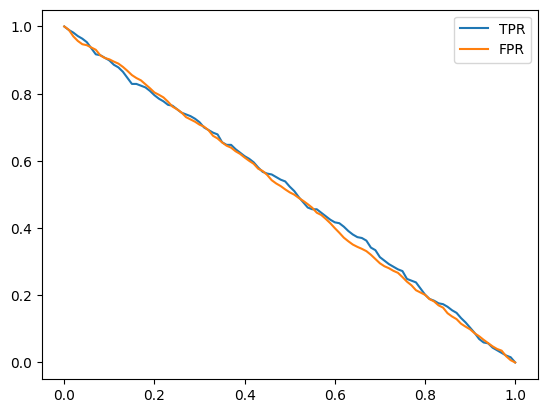

In [37]:
# Plotting the graph
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()
plt.show()

#### Ideal Model

In [38]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

(num_neg, num_pos)

(1023, 386)

In [39]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [40]:
y_ideal_pred = np.linspace(0, 1, len(y_val))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [41]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [42]:
df_ideal = tpr_fpr_dataframes(y_ideal, y_ideal_pred)

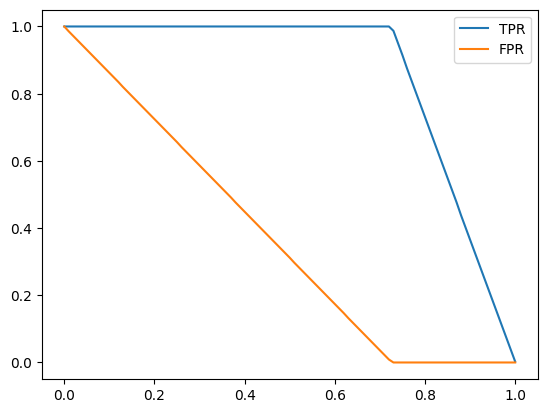

In [43]:
# Plotting the graph
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR')
plt.legend()
plt.show()

#### Putting Everthing Together

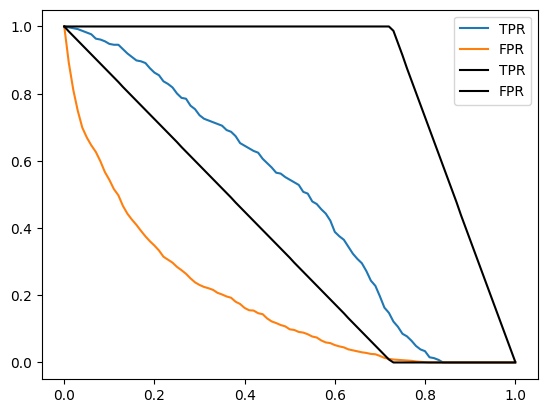

In [44]:
# Plotting the graph for actual scores
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')

# Plotting the graph for ideal model
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR', color='black')

plt.legend()
plt.show()

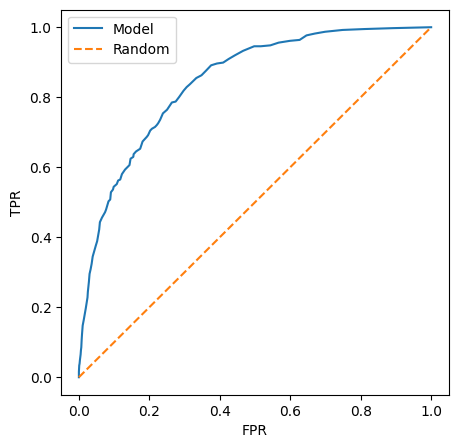

In [45]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
# plt.plot(df_rand.fpr, df_rand.tpr, label='random')
# plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.show()

#### Sklearn Library

In [46]:
from sklearn.metrics import roc_curve

In [47]:
fpr, tpr, threshold = roc_curve(y_val, y_pred)

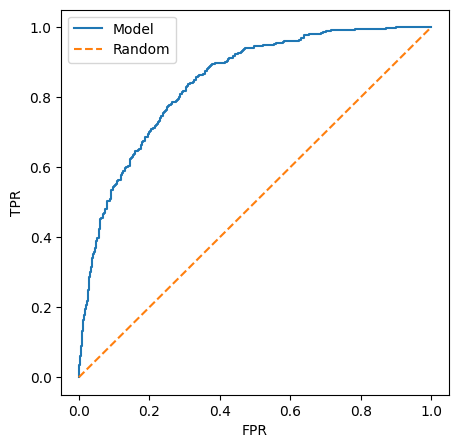

In [48]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.show()

### 6. ROC AUC
- Area under the ROC curve - useful metrics
- Interpretation of AUC

In [49]:
from sklearn.metrics import auc

In [50]:
auc(fpr, tpr)

0.8438479732980819

In [51]:
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754537

In [52]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [53]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, threshold = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438479732980819

In [54]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_pred)

0.8438479732980819

In [55]:
y_pred

array([0.00899723, 0.20452842, 0.21222586, ..., 0.1363944 , 0.79977064,
       0.83740732])

#### AUC Interpretation
Probabilty that randomly selected churned people[postive] is higher that not churned perople[negative].

In [56]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [57]:
import random

In [58]:
n = 100000
success = 0

for i in range(n):
    
    pos_idx = random.randint(0, len(pos) - 1)
    neg_idx = random.randint(0, len(neg) - 1)
    
    if pos[pos_idx] > neg[neg_idx]:
        success += 1
        
success/n

0.84273

### 7. Cross-Validation
- Evaluating the same model on different subset of data.
- Getting the average prediction and spread within predictions.
- K-fold Cross Validation

In [59]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [60]:
dv, model = train(df_train, y_train, C=0.001)

In [61]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [62]:
y_pred = predict(df_val, dv, model)

In [63]:
from sklearn.model_selection import KFold

In [64]:
from tqdm.auto import tqdm

In [65]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 14%|█▍        | 1/7 [00:02<00:12,  2.05s/it]

C=0.001 0.825 +- 0.009


 29%|██▊       | 2/7 [00:04<00:10,  2.09s/it]

C=0.01 0.840 +- 0.009


 43%|████▎     | 3/7 [00:05<00:07,  1.86s/it]

C=0.1 0.841 +- 0.008


 57%|█████▋    | 4/7 [00:07<00:05,  1.79s/it]

C=0.5 0.840 +- 0.007


 71%|███████▏  | 5/7 [00:08<00:03,  1.70s/it]

C=1 0.840 +- 0.008


 86%|████████▌ | 6/7 [00:10<00:01,  1.67s/it]

C=5 0.841 +- 0.007


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]

C=10 0.841 +- 0.008


In [66]:
scores

[0.8419472333210352,
 0.8457923619388161,
 0.8329279550471604,
 0.832027003261495,
 0.8525383577546987]

In [67]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

### 8. Summary

- **Metric:** a single number that describe the preformance of model.
- **Accuracy:** fractions of correct answer; sometime it's misleading.
- **Precision & Recall:** less misleading when class is imbalanced.
- **ROC Curve:** a way to evaluate the performance at all thresholds; okay to use with imbalance
- **K-Fold CV:** more reliable estimates the performance(mean + std)  

### 9. Explore More

- Check the precision and recall of the dummy classifier that always predict 'FALSE'
- F1 score = 2 * P * R / (P + R)
- Evaluate precision and recall at different thresholds, plot P vs R - this way you will get precision and recall curve (similar to ROC curve)
- Are under the PR curve is also useful metric